![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

# Advanced Predictive Modeling with Python 
## Session #1: Features
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

# Preliminaries

1.  If you haven't do so already, download and **install the [Anaconda Scientific Python Distribution version 2.7](https://store.continuum.io/cshop/anaconda/)**.  If it offers to make itself your default Python distribution, allow it.
1. Whether you've just installed Anaconda, or you have done so previously, you should now **update Anaconda** to the latest version of the distribution.  It changes a lot so do this today even if you did recently.
 1. Open a terminal or command prompt.
 1. Type ```conda update conda``` and press enter or return.  Confirm that you'd like it to make any changes that it offers.
 1. Type ```conda update anaconda``` and press enter or return.  Confirm that you'd like it to make any changes that it offers.
1. **Download the code repository**.  
 1. Go to [bit.ly/uci_predictive](http://bit.ly/uci_predictive) and click the "download zip" button on the right to download a zip file containing this entire repository.
 1. Unzip that file into a directory you know how to find; you'll need it several times throughout the day.  
1. **Start an ipython notebook server**.
 1. Open a terminal and type ```ipython notebook```.  Navigate to the directory where you unzipped this repository.
 1. Open "Test Notebook.ipynb".
 1. Click "Cell" at the top of the opened notebook, followed by "Run All" and ensure that 1) there are no errors and that 2) the output from the first cell is the same as that in the second.  If it doesn't match, raise your hand.
 1. If everything looks good, close the browser tab containing the test notebook but keep open the tab listing all the other notebooks.
 
### Schedule for Today

|Start Time | Session |
|-----------|---------|
|8:30am     | Check In|
|9:00am     | **Feature Engineering** |
|10:30am    | Coffee & Bagels|
|10:45am    | **Ensembling** |
|12:30pm    | End|

### Goals of this Lesson
- Extend the regression framework to support classification
    - Logistic Regression
    - Training with Gradient Descent
    - Training with Newton's Method
    
- Implement... 
    - The Logistic Function
    - A function to compute the Hessian matrix
    - An instantiation of SciKit-Learn's Logistic regression class

### References 
- Chapter 14 of [*Elements of Statistical Learning* by Hastie, Tibshirani, Friedman](http://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf)
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [SciKit-Learn's documentation on data preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
- [SciKit-Learn's documentation on dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions)

## 0.  Preliminaries
First we need to import Numpy, Pandas, MatPlotLib...

In [227]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

I've created some functions that we'll use later to create visualizations.  They are a bit messy and not essential to the material so don't worry about understanding them.  I'll be happy to explain them to anyone interested during a break or after the session.  

In [228]:
from matplotlib.colors import ListedColormap

# Another messy looking function to make pretty plots of basketball courts
def visualize_court(log_reg_model, coord_type='cart', court_image = '../data/nba/nba_court.jpg'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    features = np.c_[grid_x.ravel(), grid_y.ravel()]
    # change coordinate system
    if coord_type == 'polar':
        features = np.c_[grid_x.ravel(), grid_y.ravel()]
        hoop_location = np.array([25., 0.])
        features -= hoop_location
        dists = np.sqrt(np.sum(features**2, axis=1))
        angles = np.arctan2(features[:,1], features[:,0])
        features = np.hstack([dists[np.newaxis].T, angles[np.newaxis].T])
        
    grid_predictions = log_reg_model.predict(features)
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

We also need functions for performing common tasks such as shuffling the data and calculating classification errrors.  

In [229]:
### function for shuffling the data and labels
def shuffle_in_unison(features, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(features)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

### calculate mean squared error (MSE)
def calc_mse(predictions, responses):
    return np.mean( (predictions - responses)**2 )


## 1.  Warm-up

Let's start with a warm-up exercise.  In the data directory you'll find a dataset of recent movies and their ratings as given by several popular websites.  Let's load it with Pandas...  

In [230]:
# load a dataset of recent movies and their ratings across several websites
movie_data = pd.read_csv('../data/movie_ratings.csv')
# reduce it to just the ratings categories
movie_data = movie_data[['FILM','RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue', 'IMDB']]
# create classes: more or less that 7/10 rating
classes = (movie_data['IMDB'] >= 7.).astype('int')
movie_data['IMDB'] = classes
movie_data.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,Fandango_Ratingvalue,IMDB
0,Avengers: Age of Ultron (2015),74,86,66,7.1,4.5,1
1,Cinderella (2015),85,80,67,7.5,4.5,1
2,Ant-Man (2015),80,90,64,8.1,4.5,1
3,Do You Believe? (2015),18,84,22,4.7,4.5,0
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,3.0,0


In [231]:
movie_data.describe()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,Fandango_Ratingvalue,IMDB
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,60.849315,63.876712,58.808219,6.519178,3.845205,0.465753
std,30.168799,20.024430,19.517389,1.510712,0.502831,0.500543
min,5.000000,20.000000,13.000000,2.400000,2.700000,0.000000
25%,31.250000,50.000000,43.500000,5.700000,3.500000,0.000000
50%,63.500000,66.500000,59.000000,6.850000,3.900000,0.000000
75%,89.000000,81.000000,75.000000,7.500000,4.200000,1.000000
max,100.000000,94.000000,94.000000,9.600000,4.800000,1.000000


### Logistic Regression Review

_**Data**_

We observe pairs $(\mathbf{x}_{i},y_{i})$ where
\begin{eqnarray*}
y_{i} \in \{ 0, 1\} &:& \mbox{class label} \\
\mathbf{x}_{i} = (1, x_{i,1}, \dots, x_{i,D}) &:& \mbox{set of $D$ explanatory variables (aka features) and a bias term } 
\end{eqnarray*}

_** Parameters**_

\begin{eqnarray*}
\mathbf{\beta}^{T} = (\beta_{0}, \dots, \beta_{D}) : \mbox{values encoding the relationship between the features and label}
\end{eqnarray*}

_** Transformation Function **_

\begin{equation*}
f(z_{i}=\mathbf{x}_{i} \mathbf{\beta} ) = (1+e^{-\mathbf{x}_{i} \mathbf{\beta} })^{-1}
\end{equation*}

_**Error Function**_

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log f(\mathbf{x}_{i} \mathbf{\beta} ) - (1-y_{i}) \log (1-f(\mathbf{x}_{i} \mathbf{\beta} ))
\end{eqnarray*}

_** Learning $\beta$ **_
- Randomly initialize $\beta$
- Until $\alpha || \nabla \mathcal{L} || < tol $:
    - $\mathbf{\beta}_{t+1} = \mathbf{\beta}_{t} - \alpha \nabla_{\mathbf{\beta}} \mathcal{L}$

## <span style="color:red">STUDENT ACTIVITY (10 MINS)</span> 
Run a logistic regression model on this data with SciKit-Learn.  If you need a refresher, [check out the notebook from the first course](https://github.com/UCIDataScienceInitiative/PredictiveModeling_withPython/blob/master/Session%203%20-%20Classification.ipynb) and the [SciKit-Learn documentation on logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [245]:
from sklearn import linear_model

# set the random number generator for reproducability
np.random.seed(123)

# let's try to predict the IMDB rating from the others
features = movie_data[['RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue']].as_matrix()
labels = movie_data['IMDB'].as_matrix()
shuffle_in_unison(features, labels)

# initialize and train a logistic regression model
lm = linear_model.LogisticRegression()
lm.fit(features, labels)

### compute error on training data
predictions = lm.predict(features)
print "Classification error on training set: %.2f%%" %(calc_classification_error(predictions, labels)*100)

Classification error on training set: 44.52%


## 2.  Feature Transformations
Good features are crucial for training well-performing classifiers: 'garbage in, garbage out.'  In this section we introduce several transformations that are commonly applied to data as a preprocessing step before training a classifier.

### 2.1 Normal Standardization
Recall the formula of the standard linear model: $$\hat Y = f(\beta^{T} \mathbf{X}) $$ where $\hat Y$ is the predictions, $f(\cdot)$ is the transformation function, $\beta$ is the weights (parameters), and $X$ is the $N \times d$ matrix of features.  For simplicity, assume there are just two features: $$ \beta^{T} X_{i} = \beta_{1}x_{i,1} + \beta_{2}x_{i,2}.$$  Usually $x_{i,1}$ and $x_{i,2}$ will be measured in different units.  For instance, in the movie ratings data, the Rotten Tomatoes dimension is on a $0-100$ scale and the Fandango ratings are on $0-5$.  The difference in scale causes one dimension to dominate the inner product.  Linear models can learn to cope with this imbalance by changing the scales of the weights accordingly, but this makes optimization harder because gradient steps are unequal across dimensions.

One way to get rid of hetergeneous scales is to standardize the data so that the values in each dimension are distributed according to the standard Normal distribution.  In math, this means we'll transform the data like so: $$\mathbf{X}_{std} = \frac{\mathbf{X} - \mu_{X}}{\sigma_{X}}. $$  This is also called 'z-score scaling.'  Let's examine the affect of this transformation on training error.

In [242]:
# perform z-score scaling
features_mu = np.mean(features, axis=0)
features_sigma = np.std(features, axis=0)
std_features = (features - features_mu)/features_sigma

# re-train model
lm.fit(std_features, labels)

### compute error on training data
predictions = lm.predict(std_features)
print "Classification error on training set: %.3f%%" %(calc_classification_error(predictions, labels)*100)

Classification error on training set: 39.726%


Standard Normal scaling is a common and usually default first step, especially when you know the data in measured in different units.

### 2.2 Log Transformations

### 2.3 Domain-Specific Transformations

Training ended after 0.45 seconds.
Classification Error on the Test Set: 41.87%
Baseline Error: 45.79%


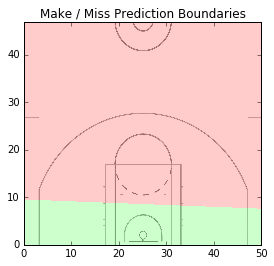

In [243]:
nba_shot_data = pd.read_csv('../data/nba/NBA_xy_features.csv')

# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']].as_matrix()
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']].as_matrix()
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']].as_matrix()
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']].as_matrix()

#Train it
start_time = time.time()
lm.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = lm.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(lm)

Training ended after 0.81 seconds.
Classification Error on the Test Set: 41.07%
Baseline Error: 45.79%


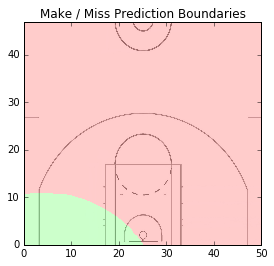

In [284]:
### Transform coordinate system
# radius coordinate: calculate distance from point to hoop
hoop_location = np.array([25.5, 0.])
train_features -= hoop_location
test_features -= hoop_location
train_dists = np.sqrt(np.sum(train_features**2, axis=1))
test_dists = np.sqrt(np.sum(test_features**2, axis=1))
# angle coordinate: use arctan2 function
train_angles = np.arctan2(train_features[:,1], train_features[:,0])
test_angles = np.arctan2(test_features[:,1], test_features[:,0])
# combine vectors into polar coordinates
polar_train_features = np.hstack([train_dists[np.newaxis].T, train_angles[np.newaxis].T])
polar_test_features = np.hstack([test_dists[np.newaxis].T, test_angles[np.newaxis].T])

#Train model
start_time = time.time()
lm.fit(polar_train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on test data
predictions = lm.predict(polar_test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(lm, coord_type='polar')

## 3.  Dimensionality Reduction
Sometimes the data calls for more aggressive transformations.  High-dimensional data is usually hard to model because classifiers are likely to [overfit](https://en.wikipedia.org/wiki/Overfitting).  Regularization is one way to combat high dimensionality, but often it can not be enough.  This section will cover *dimensionality reduction*--a technique for reducing the number of features while still preserving curcial information.    

### Dataset: [Bob Ross](https://en.wikipedia.org/wiki/Bob_Ross) Paintings
![alt text](http://i2.wp.com/espnfivethirtyeight.files.wordpress.com/2014/04/bob-ross1.jpg?quality=70&strip=all&w=600&ssl=1 'Bob_Ross_Banner')
In this section we'll use a dataset of [Bob Ross'](https://en.wikipedia.org/wiki/Bob_Ross) paintings.  Images are a type of data that notoriously have redundant features and whose dimensionality can be reduced significantly, without much loss of information.  We'll explore this phenomenom via 403 $400 \times 300$ images of natural landscape paintings. 

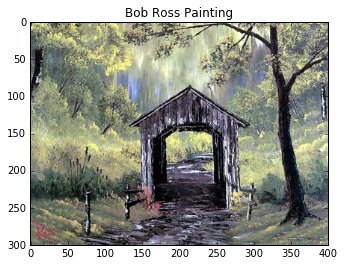

In [297]:
# load the Pillow image library
import PIL.Image as pImage

paintings = np.load(open('../data/bob_ross/bob_ross_paintings.npy', 'rb'))
br_painting = paintings[31,:]
fig, ax = plt.subplots()
ax.imshow(np.reshape(br_painting, (300, 400, 3)))
plt.title('Bob Ross Painting')
plt.show()